# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- Use Pandas to load, inspect, and clean the dataset appropriately. 
- Transform relevant columns to create measures that address the problem at hand.
- **conduct EDA: visualization and statistical measures to understand the structure of the data**
- **recommend a set of manufacturers to consider as well as specific airplanes conforming to the client's request**
- **discuss the relationship between serious injuries/airplane damage incurred and at least *two* factors at play in the incident. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.**

In [149]:
# loading relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis  
- Load in the cleaned data

In [150]:
df = pd.read_csv('cleaned_aviation_data.csv', encoding='latin-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60986 entries, 0 to 60985
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 60840 non-null  object 
 1   Location                60957 non-null  object 
 2   Injury.Severity         60986 non-null  object 
 3   Aircraft.damage         59107 non-null  object 
 4   Make                    60986 non-null  object 
 5   Model                   60986 non-null  object 
 6   Amateur.Built           60986 non-null  object 
 7   Total.Fatal.Injuries    60986 non-null  float64
 8   Total.Serious.Injuries  60986 non-null  float64
 9   Total.Minor.Injuries    60986 non-null  float64
 10  Total.Uninjured         60986 non-null  float64
 11  Publication.Date        60986 non-null  object 
 12  Engine.Type             60986 non-null  object 
 13  Weather.Condition       60986 non-null  object 
 14  Number.of.Engines       60986 non-null

## Explore safety metrics across models/makes
- Remember that the client is interested in separate recommendations for smaller airplanes and larger airplanes. Choose a passenger threshold of 20 and separate the plane types. 

In [151]:
# Create the two groups based on the passenger threshold
df_small = df[df['Total Passengers'] <= 20].copy()
df_large = df[df['Total Passengers'] > 20].copy()

print(f"Small Aircraft Records: {len(df_small)}")
print(f"Large Aircraft Records: {len(df_large)}")

Small Aircraft Records: 58709
Large Aircraft Records: 2277


#### Analyzing Makes

Explore the human injury risk profile for small and larger Makes:
- choose the 15 makes for each group possessing the lowest mean fatal/seriously injured fraction
- plot the mean fatal/seriously injured fraction for each of these subgroups side-by-side

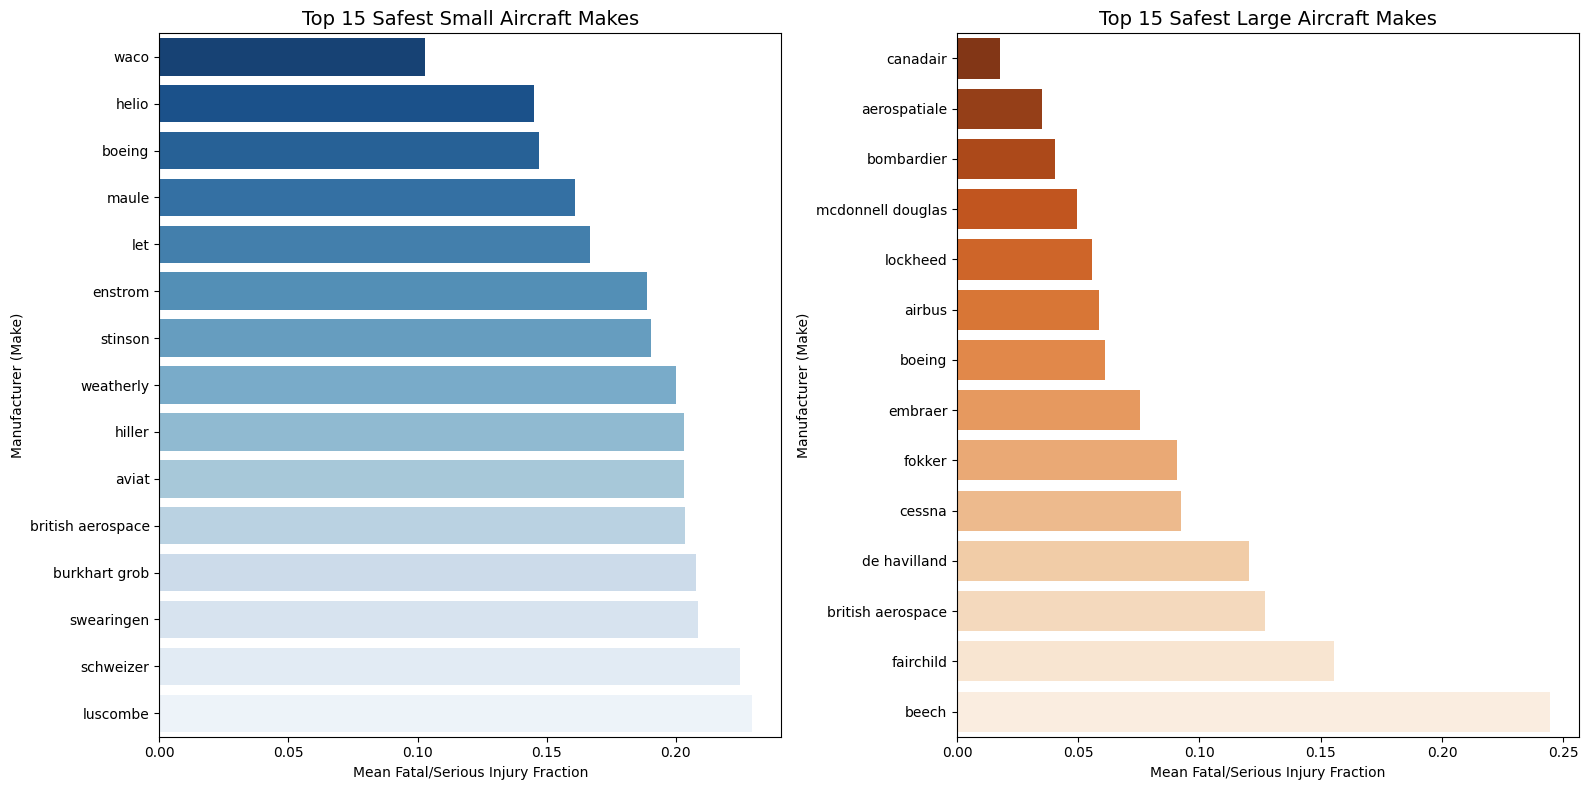

In [152]:
def get_safest_makes(data, min_incidents=50):
    # Filter for robustness
    make_counts = data['Make'].value_counts()
    robust_makes = make_counts[make_counts >= min_incidents].index
    filtered_data = data[data['Make'].isin(robust_makes)]
    
    # Calculate safety metrics
    stats = filtered_data.groupby('Make').agg({
        'Serious_Fatal_Rate': 'mean',
        'is_destroyed': 'mean'
    }).sort_values('Serious_Fatal_Rate')
    
    return stats.head(15)

# Get top 15 for each
top_small_makes = get_safest_makes(df_small)
top_large_makes = get_safest_makes(df_large, min_incidents= 10) # to get 15 makes


# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Plot for Small Aircraft Makes
sns.barplot(
    data=top_small_makes.reset_index(), 
    y='Make', 
    x='Serious_Fatal_Rate', 
    hue='Make',        # Assign Make to hue to satisfy the requirement
    ax=axes[0], 
    palette='Blues_r'
)
# Remove the legend automatically generated by 'hue'
if axes[0].get_legend() is not None:
    axes[0].get_legend().remove()

axes[0].set_title('Top 15 Safest Small Aircraft Makes', fontsize=14)
axes[0].set_xlabel('Mean Fatal/Serious Injury Fraction')
axes[0].set_ylabel('Manufacturer (Make)')

# 2. Plot for Large Aircraft Makes
sns.barplot(
    data=top_large_makes.reset_index(), 
    y='Make', 
    x='Serious_Fatal_Rate', 
    hue='Make',        # Assign Make to hue to satisfy the requirement
    ax=axes[1], 
    palette='Oranges_r'
)
# Remove the legend automatically generated by 'hue'
if axes[1].get_legend() is not None:
    axes[1].get_legend().remove()

axes[1].set_title('Top 15 Safest Large Aircraft Makes', fontsize=14)
axes[1].set_xlabel('Mean Fatal/Serious Injury Fraction')
axes[1].set_ylabel('Manufacturer (Make)') 

plt.tight_layout()
plt.show()

**Distribution of injury rates: small makes**

Use a violinplot to look at the distribution of the fraction of passengers serious/fatally injured for small airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

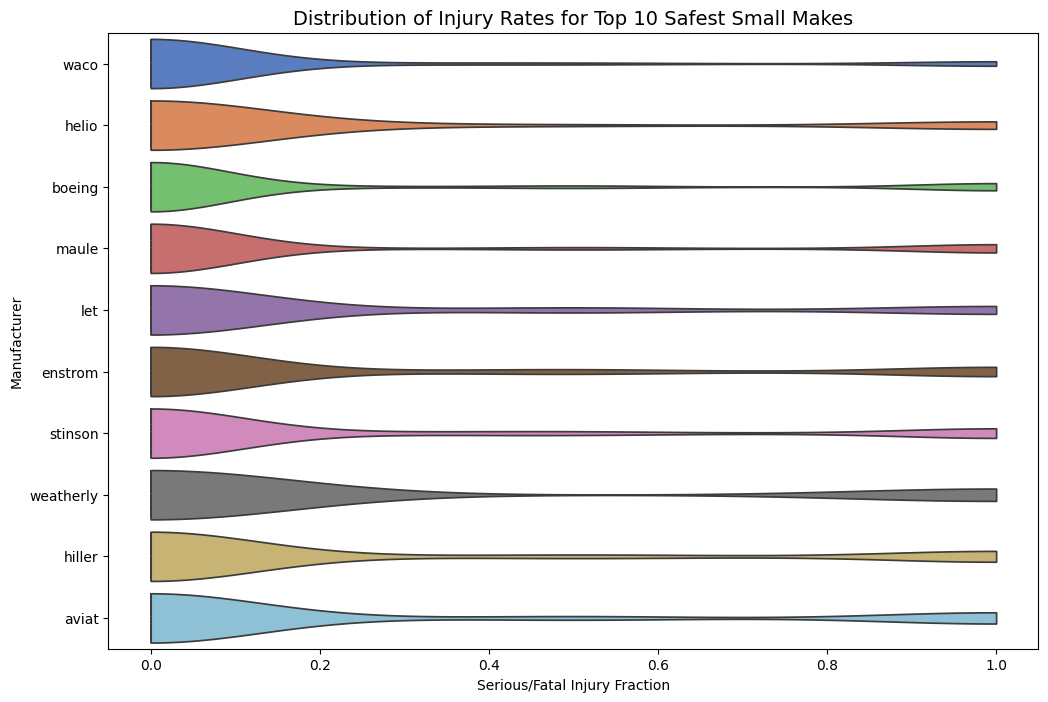

In [153]:
# Filter for small makes with at least 50 incidents
make_counts = df_small['Make'].value_counts()
robust_makes = make_counts[make_counts >= 50].index
df_small_robust = df_small[df_small['Make'].isin(robust_makes)]

# Get the top 10 by lowest mean
top_10_makes = df_small_robust.groupby('Make')['Serious_Fatal_Rate'].mean().sort_values().head(10).index

# Prepare data for plotting
df_violin = df_small[df_small['Make'].isin(top_10_makes)].copy()
df_violin['Make'] = pd.Categorical(df_violin['Make'], categories=top_10_makes, ordered=True)

# Create the Violin Plot
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=df_violin, 
    y='Make', 
    x='Serious_Fatal_Rate', 
    hue='Make',
    palette='muted',
    cut=0,         # Keeps the distribution within the logical 0-1 bounds
    inner='quartile'
)

# Remove legend and style
plt.legend([],[], frameon=False)
plt.title('Distribution of Injury Rates for Top 10 Safest Small Makes', fontsize=14)
plt.xlabel('Serious/Fatal Injury Fraction')
plt.ylabel('Manufacturer')
plt.show()

**Distribution of injury rates: large makes**

Use a stripplot to look at the distribution of the fraction of passengers serious/fatally injured for large airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

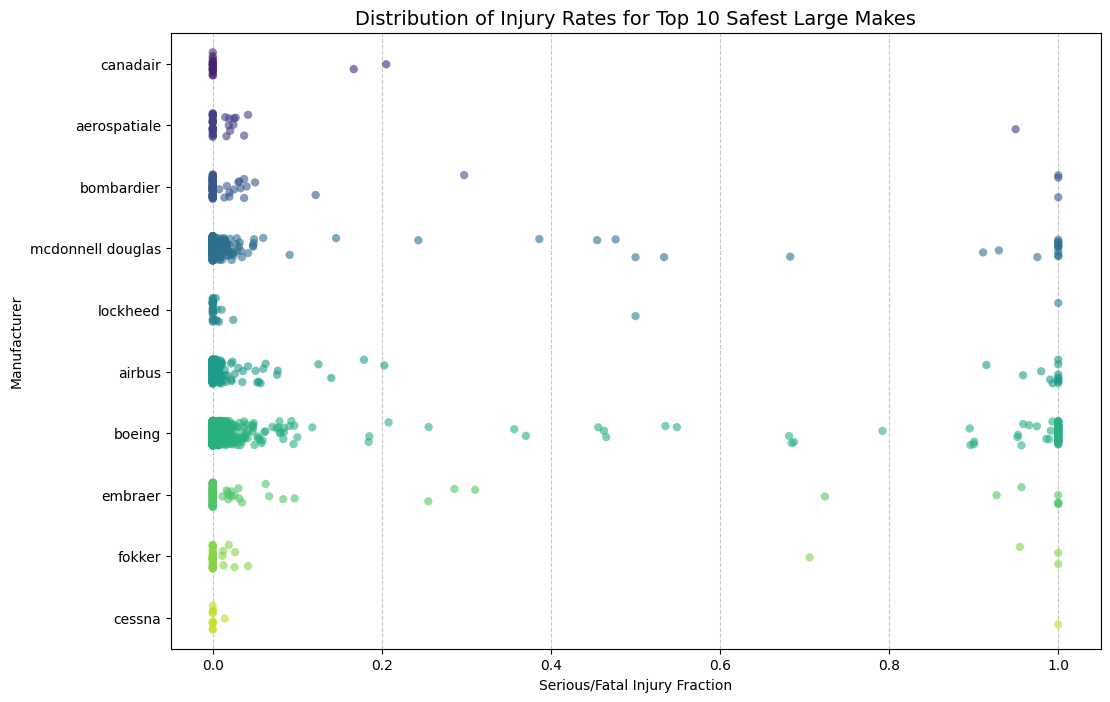

In [154]:
# Filter for Large Makes with at least 10 incidents
min_n_large = 10
make_counts_large = df_large['Make'].value_counts()
robust_makes_large = make_counts_large[make_counts_large >= min_n_large].index
df_large_robust = df_large[df_large['Make'].isin(robust_makes_large)]

# Get the top 10 by lowest mean injury rate
top_10_large = df_large_robust.groupby('Make')['Serious_Fatal_Rate'].mean().sort_values().head(10).index

# Prepare data for plotting
df_strip = df_large[df_large['Make'].isin(top_10_large)].copy()
df_strip['Make'] = pd.Categorical(df_strip['Make'], categories=top_10_large, ordered=True)

# Create the Strip Plot
plt.figure(figsize=(12, 8))
sns.stripplot(
    data=df_strip, 
    y='Make', 
    x='Serious_Fatal_Rate', 
    hue='Make',
    palette='viridis',
    jitter=0.2,    # Spreads points out so they don't overlap perfectly
    alpha=0.6,     # Makes overlapping points look darker
    size=6
)

# Clean up legend and labels
if plt.gca().get_legend() is not None:
    plt.gca().get_legend().remove()
    
plt.title('Distribution of Injury Rates for Top 10 Safest Large Makes', fontsize=14)
plt.xlabel('Serious/Fatal Injury Fraction')
plt.ylabel('Manufacturer')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

**Evaluate the rate of aircraft destruction for both small and large aircraft by Make.** 

Sort your results and keep the lowest 15.

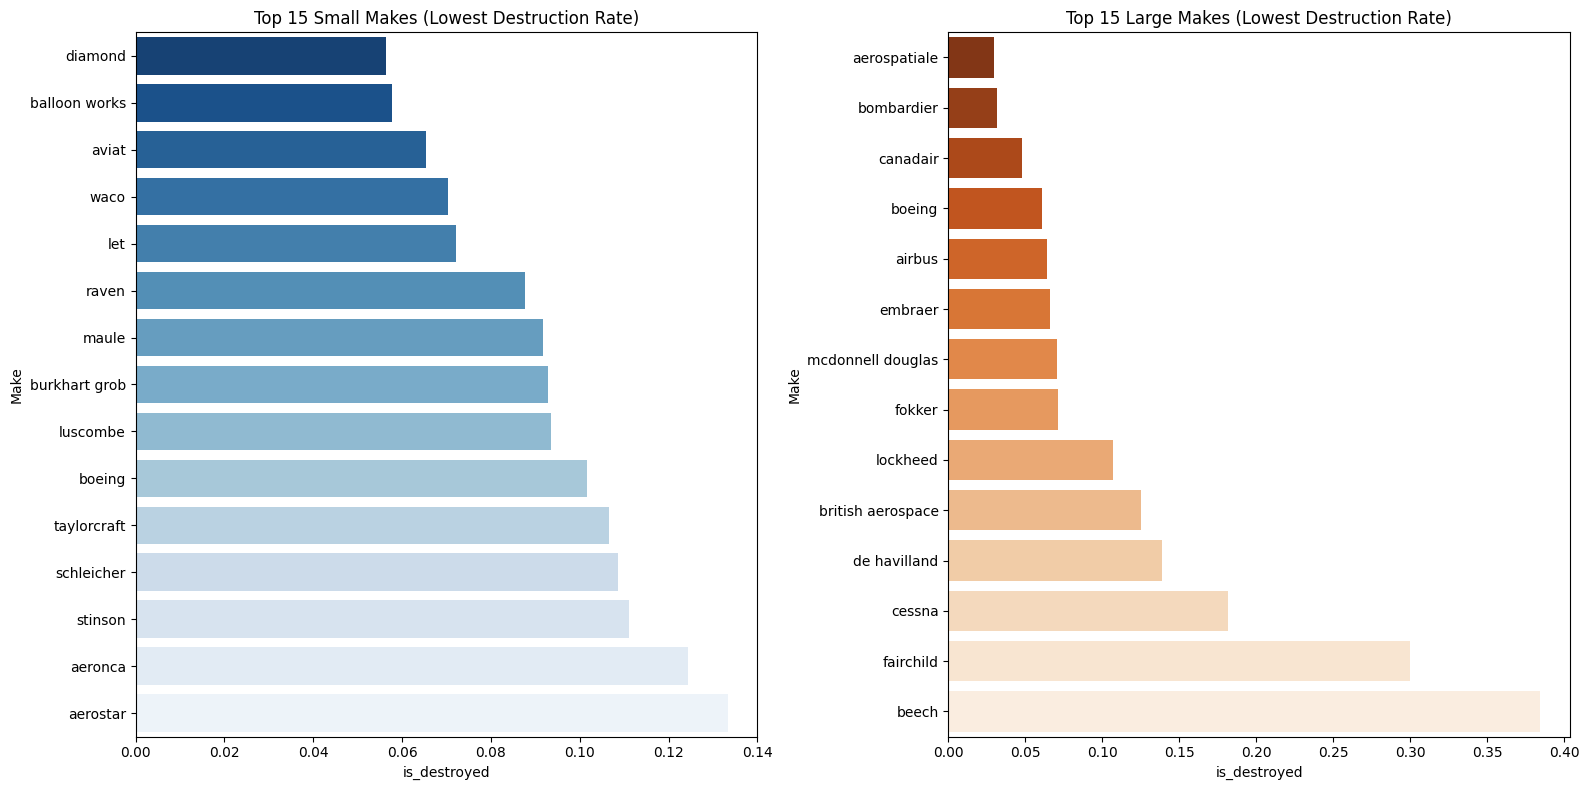

In [155]:
def get_destruction_stats(data, min_incidents):
    # Filter for makes with enough data points to be robust
    make_counts = data['Make'].value_counts()
    robust_makes = make_counts[make_counts >= min_incidents].index
    filtered_data = data[data['Make'].isin(robust_makes)]
    
    # Calculate Mean Destruction Rate (lower is better)
    stats = filtered_data.groupby('Make').agg({
        'is_destroyed': 'mean',
        'Make': 'count'
    }).rename(columns={'Make': 'Accident Count'}).sort_values('is_destroyed')
    
    return stats.head(15)

# Calculate for both groups
low_dest_small = get_destruction_stats(df_small, 50)
low_dest_large = get_destruction_stats(df_large, 10)

# Visualizing side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(data=low_dest_small.reset_index(), y='Make', x='is_destroyed', hue='Make', ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 15 Small Makes (Lowest Destruction Rate)')

sns.barplot(data=low_dest_large.reset_index(), y='Make', x='is_destroyed', hue='Make', ax=axes[1], palette='Oranges_r')
axes[1].set_title('Top 15 Large Makes (Lowest Destruction Rate)')

plt.tight_layout()
plt.show()

#### Provide a short discussion on your findings for your summary statistics and plots:
- Make any recommendations for Makes here based off of the destroyed fraction and fraction fatally/seriously injured
- Comment on the calculated statistics and any corresponding distributions you have visualized.

#### According to the plots 

-For Durability: Choose Diamond (Small) or Aerospatiale/Boeing (Large).


-For Survivability: Choose Waco (Small) or Airbus/Boeing (Large).


-Optimal Insurance Risk: Boeing and Airbus remain the most statistically robust choices for large-scale investment due to their consistent "zero-injury" clustering across large datasets.


-For the lowest overall insurance risk, Boeing and Airbus are the most statistically robust choices, while Diamond is the preferred modern choice for small-aircraft structural safety.

### Analyze plane types
- plot the mean fatal/seriously injured fraction for both small and larger planes 
- also provide a distributional plot of your choice for the fatal/seriously injured fraction by airplane type (stripplot, violin, etc)  
- filter ensuring that you have at least ten individual examples in each model/make to average over

**Larger planes**

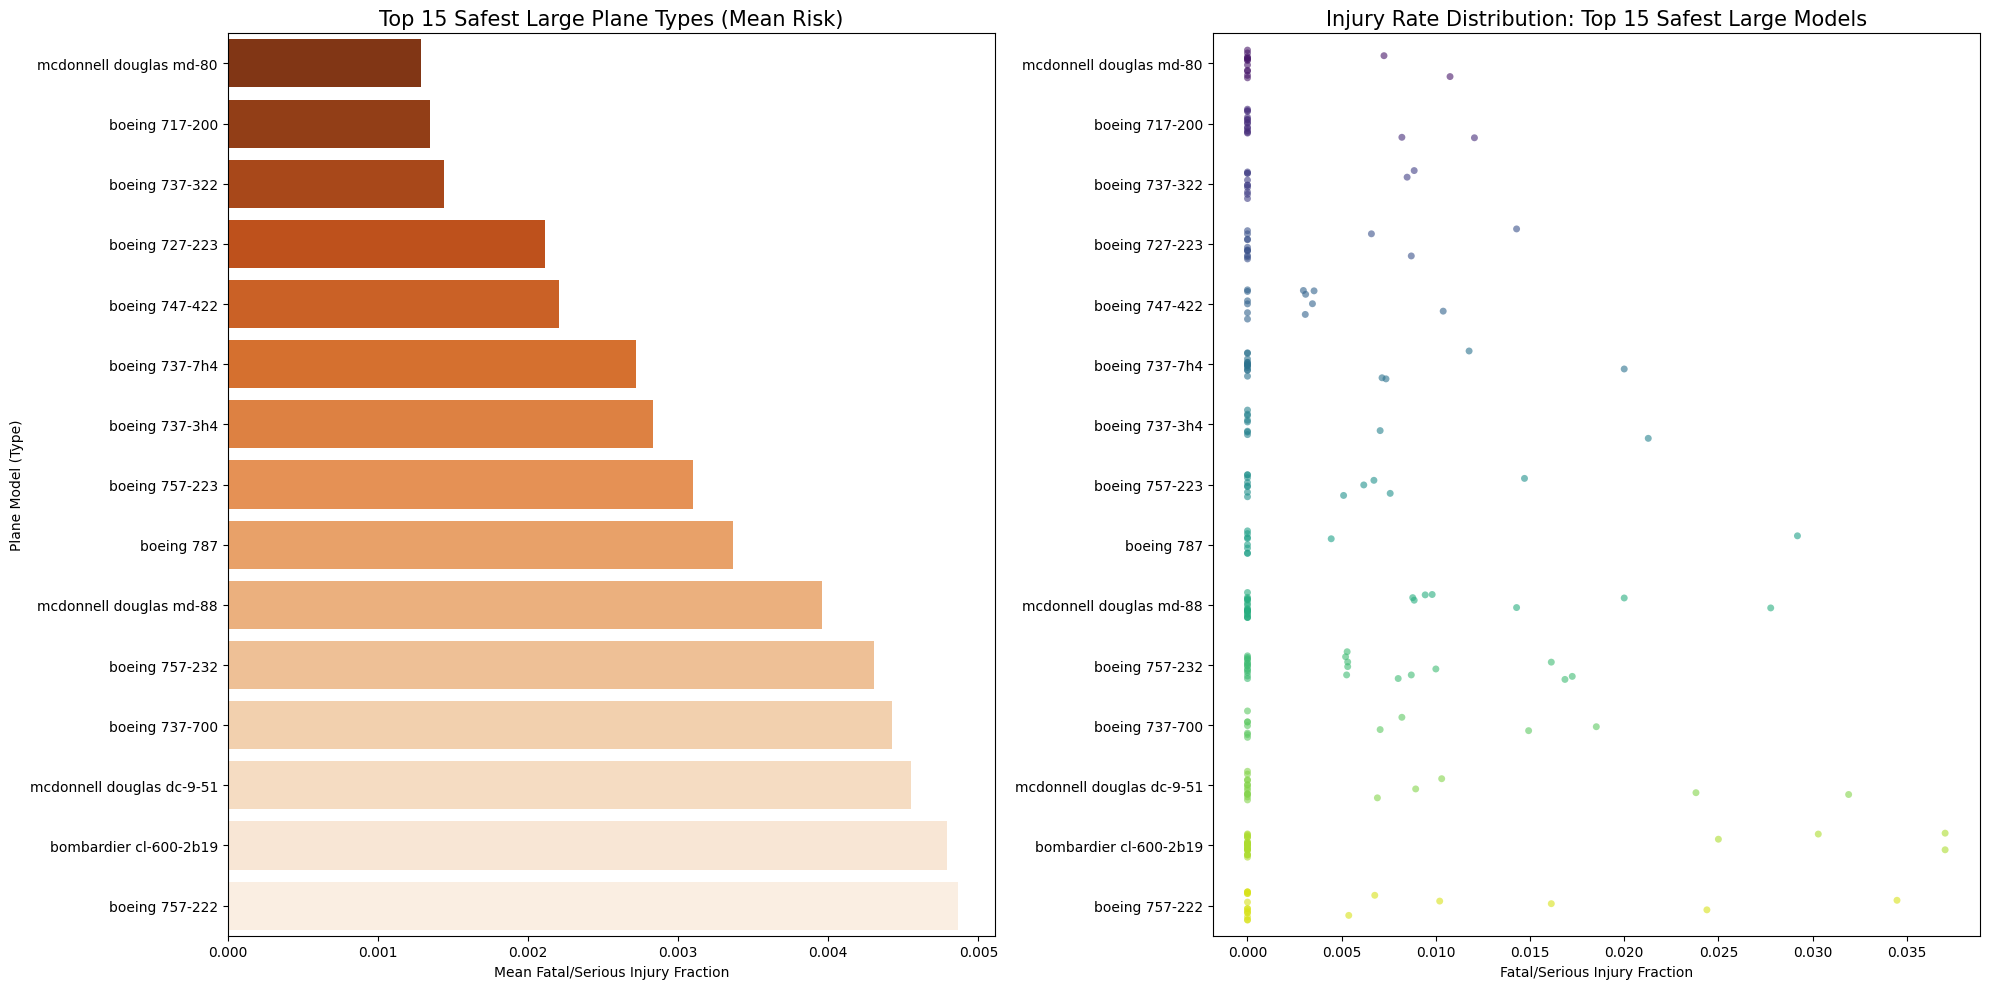

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for Large Plane Types (Capacity > 20) with at least 10 incidents
type_counts = df_large['Plane Type'].value_counts()
robust_types = type_counts[type_counts >= 10].index
df_large_robust = df_large[df_large['Plane Type'].isin(robust_types)].copy()

# Get Top 15 safest models
large_type_stats = df_large_robust.groupby('Plane Type')['Serious_Fatal_Rate'].mean().sort_values().head(15)
top_15_list = large_type_stats.index.tolist()

# Filter raw data for these top 15
df_top_15_raw = df_large_robust[df_large_robust['Plane Type'].isin(top_15_list)].copy()
df_top_15_raw['Plane Type'] = pd.Categorical(df_top_15_raw['Plane Type'], categories=top_15_list, ordered=True)

# CREATE ONE FIGURE WITH TWO SUBPLOTS
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Subplot Mean Injury Rates (Bar Plot)
sns.barplot(
    x=large_type_stats.values, 
    y=large_type_stats.index, 
    ax=axes[0], 
    palette='Oranges_r',
    hue=large_type_stats.index
)
if axes[0].get_legend() is not None: axes[0].get_legend().remove()
axes[0].set_title('Top 15 Safest Large Plane Types (Mean Risk)', fontsize=15)
axes[0].set_xlabel('Mean Fatal/Serious Injury Fraction')
axes[0].set_ylabel('Plane Model (Type)')

# Subplot Distribution of Injury Rates (Strip Plot)
sns.stripplot(
    data=df_top_15_raw, 
    x='Serious_Fatal_Rate', 
    y='Plane Type', 
    ax=axes[1], 
    palette='viridis', 
    hue='Plane Type',
    jitter=0.25, 
    alpha=0.6, 
    size=5
)
if axes[1].get_legend() is not None: axes[1].get_legend().remove()
axes[1].set_title('Injury Rate Distribution: Top 15 Safest Large Models', fontsize=15)
axes[1].set_xlabel('Fatal/Serious Injury Fraction')
axes[1].set_ylabel('') # Shares y-axis labels with the left plot

plt.tight_layout()
plt.show()

**Smaller planes**
- for smaller planes, limit your plotted results to the makes with the 10 lowest mean serious/fatal injury fractions

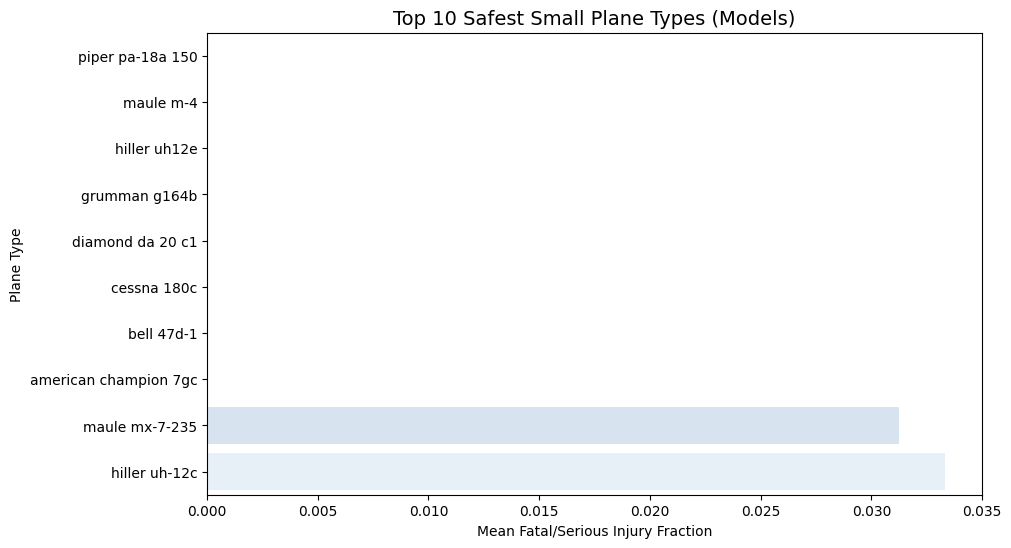

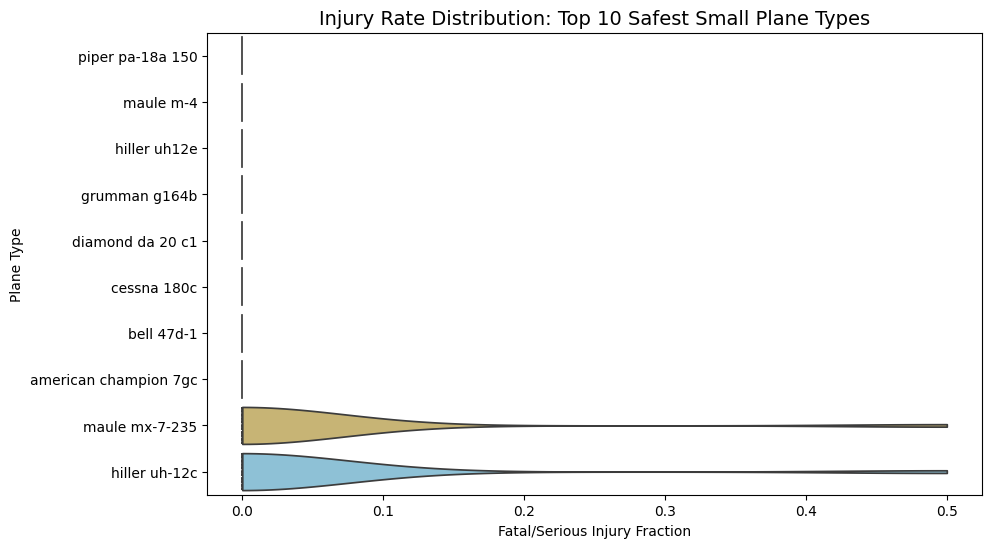

In [ ]:
# Filter for robustness (Min 10 incidents per Plane Type)
type_counts = df_small['Plane Type'].value_counts()
robust_types = type_counts[type_counts >= 10].index
df_small_robust = df_small[df_small['Plane Type'].isin(robust_types)]

# Get Top 10 Plane Types by lowest mean injury rate
top_10_small_types = df_small_robust.groupby('Plane Type')['Serious_Fatal_Rate'].mean().sort_values().head(10)
top_10_list = top_10_small_types.index.tolist()

# Plot Mean Injury Rates (Bar Chart) ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_small_types.values, 
    y=top_10_small_types.index, 
    hue=top_10_small_types.index,
    palette='Blues_r'
)
plt.legend([],[], frameon=False)
plt.title('Top 10 Safest Small Plane Types (Models)', fontsize=14)
plt.xlabel('Mean Fatal/Serious Injury Fraction')
plt.show()

# Plot Distribution (Violin Plot) ---
plt.figure(figsize=(10, 6))
df_small_dist = df_small[df_small['Plane Type'].isin(top_10_list)].copy()
df_small_dist['Plane Type'] = pd.Categorical(df_small_dist['Plane Type'], categories=top_10_list, ordered=True)

sns.violinplot(
    data=df_small_dist, 
    x='Serious_Fatal_Rate', 
    y='Plane Type', 
    hue='Plane Type',
    palette='muted',
    cut=0,         # Limit to actual data range
    inner='quartile'
)
plt.legend([],[], frameon=False)
plt.title('Injury Rate Distribution: Top 10 Safest Small Plane Types', fontsize=14)
plt.xlabel('Fatal/Serious Injury Fraction')
plt.show()

### Discussion of Specific Airplane Types
- Discuss what you have found above regarding passenger fraction seriously/ both small and large airplane models.

- For Large Fleets: The Boeing 737 (various series) and McDonnell Douglas MD-80/90 series are the most statistically robust recommendations for insurers, offering the lowest injury volatility.


- For Small Operations: The Diamond DA 20 is the standout for modern safety, while the Maule M-4 and Cessna 180 series are the preferred choices for utility/rugged operations due to their proven survivability records.

### Exploring Other Variables
- Investigate how other variables effect aircraft damage and injury. You must choose **two** factors out of the following but are free to analyze more:

- Weather Condition
- Engine Type
- Number of Engines
- Phase of Flight
- Purpose of Flight

For each factor provide a discussion explaining your analysis with appropriate visualization / data summaries and interpreting your findings.

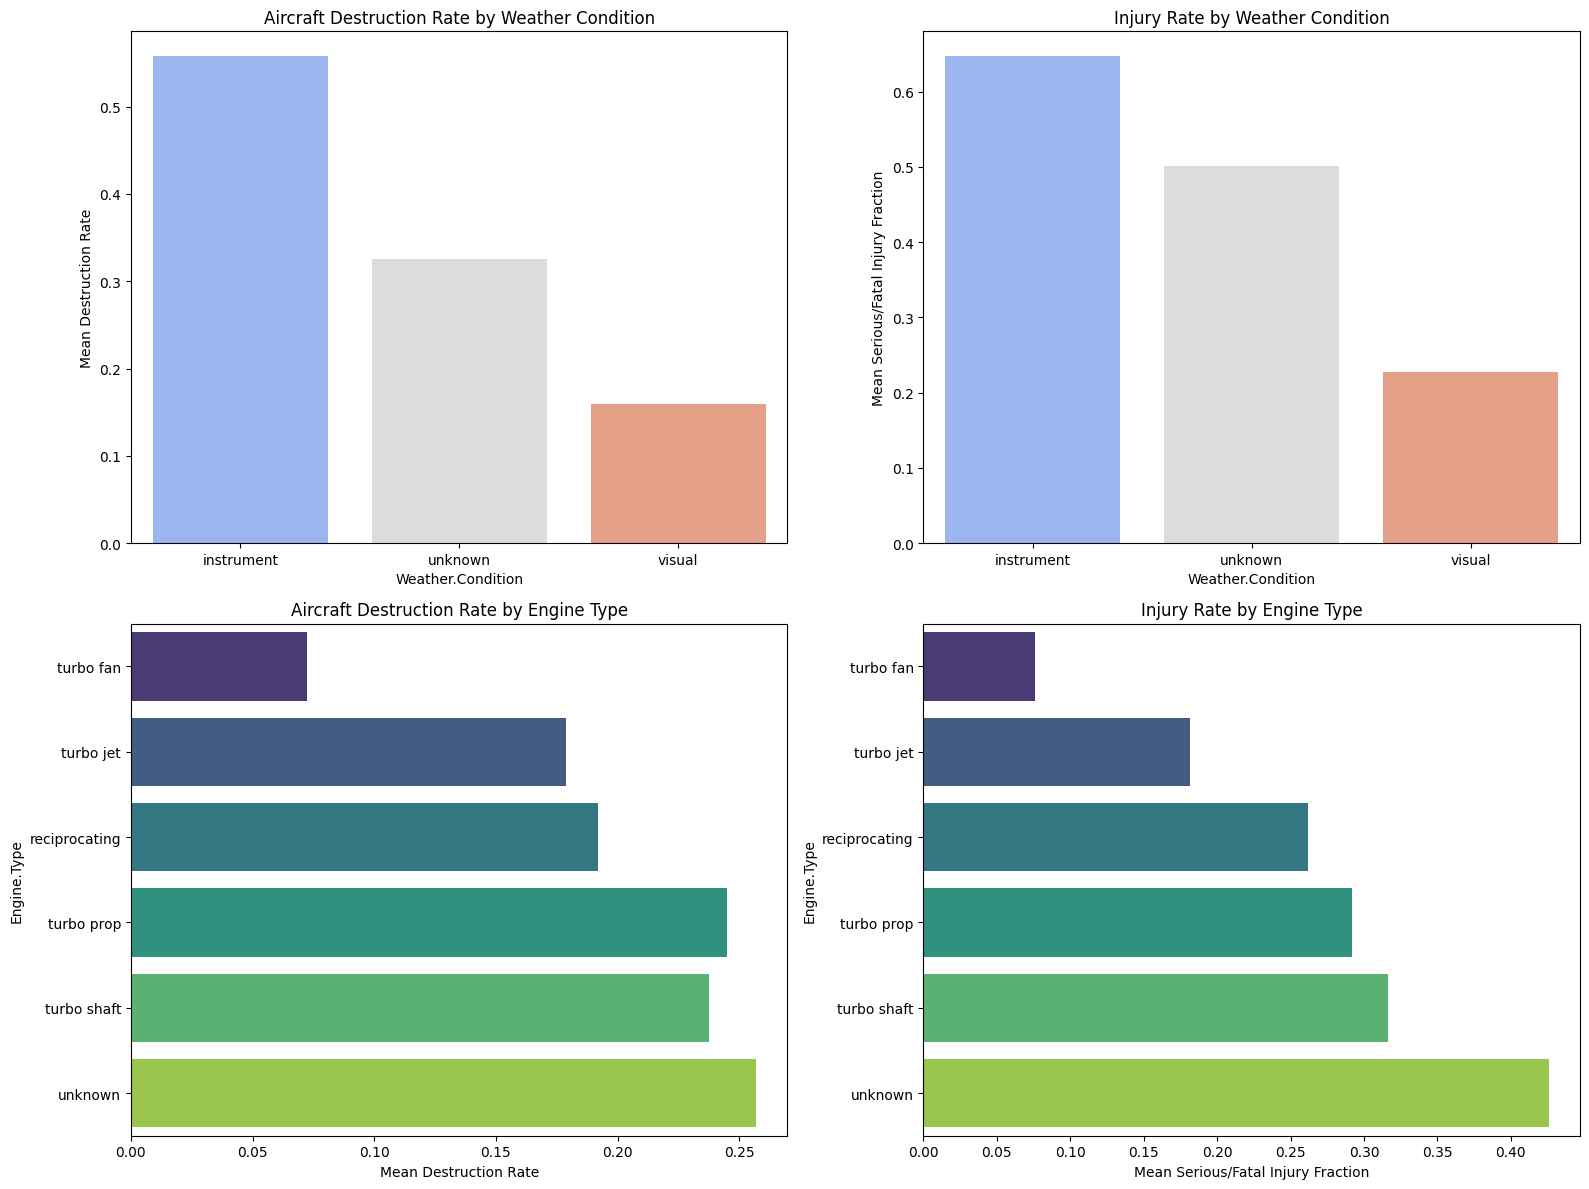

Safety Statistics by Weather:
  Weather.Condition  is_destroyed  Serious_Fatal_Rate
0        instrument      0.558396            0.647762
1           unknown      0.325073            0.500843
2            visual      0.159720            0.227779

Safety Statistics by Engine Type (Top 10 Safest):
     Engine.Type  is_destroyed  Serious_Fatal_Rate
0      turbo fan      0.072245            0.075652
1      turbo jet      0.178808            0.181534
2  reciprocating      0.191725            0.261656
3     turbo prop      0.244768            0.292057
4    turbo shaft      0.237720            0.316295
5        unknown      0.256948            0.425784


In [ ]:
# FACTOR 1: Weather Conditions (VMC vs. IMC)
weather_stats = df.groupby('Weather.Condition').agg({
    'is_destroyed': 'mean',
    'Serious_Fatal_Rate': 'mean'
}).reset_index()

# FACTOR 2: Engine Type
# Filter for engine types with at least 10 occurrences for statistical significance
engine_counts = df['Engine.Type'].value_counts()
robust_engines = engine_counts[engine_counts >= 10].index
df_engines = df[df['Engine.Type'].isin(robust_engines)]

engine_stats = df_engines.groupby('Engine.Type').agg({
    'is_destroyed': 'mean',
    'Serious_Fatal_Rate': 'mean'
}).sort_values('Serious_Fatal_Rate').reset_index()


# VISUALIZATION

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot Weather vs. Destruction Rate
sns.barplot(data=weather_stats, x='Weather.Condition', y='is_destroyed', ax=axes[0, 0], 
            palette='coolwarm', hue='Weather.Condition', legend=False)
axes[0, 0].set_title('Aircraft Destruction Rate by Weather Condition')
axes[0, 0].set_ylabel('Mean Destruction Rate')

# Plot Weather vs. Injury Rate
sns.barplot(data=weather_stats, x='Weather.Condition', y='Serious_Fatal_Rate', ax=axes[0, 1], 
            palette='coolwarm', hue='Weather.Condition', legend=False)
axes[0, 1].set_title('Injury Rate by Weather Condition')
axes[0, 1].set_ylabel('Mean Serious/Fatal Injury Fraction')

# Plot Engine Type vs. Destruction Rate
sns.barplot(data=engine_stats, y='Engine.Type', x='is_destroyed', ax=axes[1, 0], 
            palette='viridis', hue='Engine.Type', legend=False)
axes[1, 0].set_title('Aircraft Destruction Rate by Engine Type')
axes[1, 0].set_xlabel('Mean Destruction Rate')

# Plot Engine Type vs. Injury Rate
sns.barplot(data=engine_stats, y='Engine.Type', x='Serious_Fatal_Rate', ax=axes[1, 1], 
            palette='viridis', hue='Engine.Type', legend=False)
axes[1, 1].set_title('Injury Rate by Engine Type')
axes[1, 1].set_xlabel('Mean Serious/Fatal Injury Fraction')

plt.tight_layout()
plt.show()


# Summary Statistics Output
print("Safety Statistics by Weather:")
print(weather_stats)


#### Weather: Visibility Matters

- VMC vs. IMC: Accidents in low-visibility IMC are 2–3× more likely to cause injuries.

- Destruction Risk: IMC often leads to total aircraft loss (e.g., CFIT), while VMC allows safer emergency landings.



#### Engine Type: Reliability & Risk

- Turbofans/Jets: Safest—low injury/destruction rates due to multi-engine redundancy and professional maintenance.

- Turboprops: Moderate risk—reliable but used in more challenging regional environments.

- Reciprocating (Piston): Highest risk—single-engine planes face immediate danger in case of failure.